<a href="https://colab.research.google.com/github/Daisuke0209/sparse_modeling/blob/master/190530_Lasso_ADMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasso_ADMMの使い方
ハカルスが提供しているスパースモデリング用のライブラリspm-imageの中のadmm.pyに関して使い方を説明する。

## 1.概要-admm.pyとは-
admm.pyは一般化LASSOを解くためのアルゴリズムであるADMM(alternating direction method of multipliers)を利用するためのソフトである

## 2.一般化LASSOとは
一般化LASSOとは以下のような最適化問題である。  
$$
\min_{w\in \mathbb R^N} \frac{1}{2N}||X w-y||^2_2+\alpha ||Dw||_1
$$
ここで、$X \in \mathbb R^{M\times N},y\in \mathbb R^M,D\in \mathbb R^{N\times N},\alpha \in \mathbb R$。  
また、$u\in \mathbb R^N$としたとき、
$$
\begin{align*}
l^2ノルム:&||u||_2 =\sqrt{ \sum_{i=1}^{N} u_i^2 }\\
l^1ノルム:&||u||_1 = \sum_{i=1}^N |u_i|
\end{align*}
$$
となる。

## 3. 一般化LASSOの解法
一般化LASSOの解法として、次の繰り返し計算による方法が知られている。  
<dl class="theorem">　
<dt>一般化LASSOを解くためのADMMアルゴリズム</dt>
<dd>初期ベクトル$z[0],h[0] \in \mathbb R^M$および正数$\rho >0$を与えて、以下を繰り返す。  
$$
\begin{align*}
&w[k+1]=(X^TX+\rho D^TD)^{-1}(X^Ty+\rho D^T(z[k]-h[k]))\\
&z[k+1]=S(Dw[k+1]+h[k],thres)\\
&h[k+1]=h[k]+Dx[k+1]-z[k+1]
\end{align*}
$$
目的関数
$$
I(w)={2N}||X w-y||^2_2+\alpha ||Dw||_1
$$
があらかじめ与えた閾値$tol>0$を下回る、もしくは繰り返し回数がある回数まで達するまで、上を繰り返す。  
ここで、$S(u,thres)$はソフト閾値関数というものであり、以下で定義される。  
$$
\begin{equation*}
    S(w,thres) = 
\begin{cases}
    -w+thres  & w<-thres\\ 
   0 & -thres \leq w \leq thres \\
   w-thres  & w>thres 
\end{cases}
\end{equation*}
$$
($w$がベクトルの場合は、各々の成分に対して上の計算を実行する)
</dd>
</dl>

## 4. 一般化LASSOの実例（画像のノイズ除去）
一般化LASSOの応用例を一つ紹介する。画像のノイズ除去を行う。まず、ノイズが混入した画像$Y=[y_1, \cdots ,y_N]\in \mathbb R ^{N\times N}(y_i\in \mathbb R^N)$を考える。行列$Y$の各列$y_i$に対して、以下の最適化問題を解く。  
$$
\min_{x\in \mathbb R^N} ||y_i-x||_2^2+\alpha \sum_{i=1}^N |x_{i+1}-x_i|
$$  
上記最適化問題の第一項目は、ノイズの混入した観測データとなるべく近いデータ$x$を見つけるための項である。一方、第二項は隣り合うピクセルで画素値があまり変わらないことを求める項であり、**全変動**と呼ばれる。この問題は、一般化LASSOにおける、$X=I$、また、 

$$
D=
\begin{bmatrix}
-1&1&0&\cdots&0\\
0&-1&1&\ddots&\vdots\\
\vdots&\ddots&\ddots&\ddots&0\\
0&\cdots&0&-1&1\\
0&\cdots&0&0&1\\
\end{bmatrix}
$$
の場合に相当する。

## 5. spm-imageによる画像のノイズ除去の実装

### 5-1. spm-imageライブラリのインストール

In [108]:
from logging import getLogger
from abc import abstractmethod
from typing import Tuple

import numpy as np
import scipy as sp

from sklearn.utils import check_array, check_X_y
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.linear_model.coordinate_descent import _alpha_grid
from sklearn.externals.joblib import Parallel, delayed

logger = getLogger(__name__)


def _soft_threshold(X: np.ndarray, thresh: float) -> np.ndarray:
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))


def _cost_function(X, y, w, z, alpha):
    n_samples = X.shape[0]
    return np.linalg.norm(y - X.dot(w)) / n_samples + alpha * np.sum(np.abs(z))


def _update(X, y_k, D, coef_matrix, inv_Xy_k, inv_D, alpha, rho, max_iter, tol):
    # Initialize ADMM parameters
    n_samples = X.shape[0]

    w_k = X.T.dot(y_k) / n_samples
    z_k = D.dot(w_k)
    h_k = np.zeros(w_k.shape)

    cost = _cost_function(X, y_k, w_k, z_k, alpha)
    threshold = alpha / rho
    for t in range(max_iter):
        # Update
        w_k = inv_Xy_k + inv_D.dot(z_k - h_k / rho)
        Dw_t = D.dot(w_k)
        z_k = _soft_threshold(Dw_t + h_k / rho, threshold)
        h_k += rho * (Dw_t - z_k)

        # after cost
        pre_cost = cost
        cost = _cost_function(X, y_k, w_k, z_k, alpha)
        gap = np.abs(cost - pre_cost)
        if gap < tol:
            break
     
    # should return z_k as well since it's sparse by soft threshold ?!
    return w_k, t


def admm_path(X, y, Xy=None, alphas=None, eps=1e-3, n_alphas=100, rho=1.0, max_iter=1000, tol=1e-04):
    _, n_features = X.shape
    multi_output = False
    n_iters = []

    if y.ndim != 1:
        multi_output = True
        _, n_outputs = y.shape

    if alphas is None:
        alphas = _alpha_grid(X, y, Xy=Xy, l1_ratio=1.0, eps=eps, n_alphas=n_alphas)
    else:
        alphas = np.sort(alphas)[::-1]
        n_alphas = len(alphas)

    if not multi_output:
        coefs = np.zeros((n_features, n_alphas), dtype=X.dtype)
    else:
        coefs = np.zeros((n_features, n_outputs, n_alphas), dtype=X.dtype)

    for i, alpha in enumerate(alphas):
        clf = LassoADMM(alpha=alpha, rho=rho, max_iter=max_iter, tol=tol)
        clf.fit(X, y)
        coefs[..., i] = clf.coef_
        n_iters.append(clf.n_iter_)

    return alphas, coefs, n_iters


def _admm(
        X: np.ndarray, y: np.ndarray, D: np.ndarray, alpha: float,
        rho: float, tol: float, max_iter: int):
    """Alternate Direction Multiplier Method(ADMM) for Generalized Lasso.

    Minimizes the objective function::

            1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * ||z||_1

    where::

            Dw = z

    To solve this problem, ADMM uses augmented Lagrangian

            1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * ||z||_1
            + h^T (Dw - z) + rho / 2 * ||Dw - z||^2_2

    where h is Lagrange multiplier and rho is tuning parameter.
    """
    n_samples, n_features = X.shape
    n_targets = y.shape[1]

    w_t = np.empty((n_features, n_targets), dtype=X.dtype)

    # Calculate inverse matrix
    coef_matrix = X.T.dot(X) / n_samples + rho * D.T.dot(D)
    inv_matrix = np.linalg.inv(coef_matrix)
    inv_Xy = inv_matrix.dot(X.T).dot(y) / n_samples
    inv_D = inv_matrix.dot(rho * D.T)

    # Update ADMM parameters by columns
    n_iter_ = np.empty((n_targets,), dtype=int)
    if n_targets == 1:
        w_t, n_iter_[0] = _update(X, y, D, coef_matrix, inv_Xy, inv_D, alpha, rho, max_iter, tol)
    else:
        results = Parallel(n_jobs=-1, backend='threading')(
            delayed(_update)(X, y[:, k], D, coef_matrix, inv_Xy[:, k], inv_D, alpha, rho, max_iter, tol)
            for k in range(n_targets)
        )
        for k in range(n_targets):
            w_t[:, k], n_iter_[k] = results[k]

    return np.squeeze(w_t.T), n_iter_.tolist()

In [124]:
class GeneralizedLasso(LinearModel, RegressorMixin):
    """Alternate Direction Multiplier Method(ADMM) for Generalized Lasso.
    """

    def __init__(self, alpha=1.0, rho=1.0, fit_intercept=True,
                 normalize=False, copy_X=True, max_iter=1000,
                 tol=1e-4):
        self.alpha = alpha
        self.rho = rho
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.max_iter = max_iter
        self.tol = tol
        
    def fit(self, X, y, check_input=False):
        if self.alpha == 0:
            logger.warning("""
With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
""")   
        
        if check_input:
            X, y = check_X_y(X, y, accept_sparse='csc',
                             order='F', dtype=[np.float64, np.float32],
                             copy=self.copy_X and self.fit_intercept,
                             multi_output=True, y_numeric=True)
            y = check_array(y, order='F', copy=False, dtype=X.dtype.type,
                            ensure_2d=False)

        X, y, X_offset, y_offset, X_scale = self._preprocess_data(X, y, fit_intercept=self.fit_intercept,
                                                                  normalize=self.normalize,
                                                                  copy=self.copy_X and not check_input)

        if y.ndim == 1:
            y = y[:, np.newaxis]

        n_features = X.shape[1]
        D = self.generate_transform_matrix(n_features)
        self.coef_, self.n_iter_ = _admm(X, y, D, self.alpha, self.rho,
                                         self.tol, self.max_iter)
        
        if y.shape[1] == 1:
            self.n_iter_ = self.n_iter_[0]

        self._set_intercept(X_offset, y_offset, X_scale)

        # workaround since _set_intercept will cast self.coef_ into X.dtype
        self.coef_ = np.asarray(self.coef_, dtype=X.dtype)

        return self

    @abstractmethod
    def generate_transform_matrix(self, n_features: int) -> np.ndarray:
        """
        :return:
        """


class LassoADMM(GeneralizedLasso):
    """Linear Model trained with L1 prior as regularizer (aka the Lasso)
    The optimization objective for Lasso is::
        (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    """

    def generate_transform_matrix(self, n_features: int) -> np.ndarray:
        return np.eye(n_features)


class FusedLassoADMM(GeneralizedLasso):
    """Fused Lasso minimises the following objective function.

1/(2 * n_samples) * ||y - Xw||^2_2 + \lambda_1 \sum_{j=1}^p |w_j| + \lambda_2 \sum_{j=2}^p |w_j - w_{j-1}|
    """

    def __init__(self, alpha=1.0, sparse_coef=1.0, trend_coef=1.0, rho=1.0, fit_intercept=True,
                 normalize=False, copy_X=True, max_iter=1000,
                 tol=1e-4):
        super().__init__(alpha=alpha, rho=rho, fit_intercept=fit_intercept,
                         normalize=normalize, copy_X=copy_X, max_iter=max_iter,
                         tol=tol)
        self.sparse_coef = sparse_coef
        self.trend_coef = trend_coef

    def generate_transform_matrix(self, n_features: int) -> np.ndarray:
        fused = np.eye(n_features) - np.eye(n_features, k=-1)
        fused[0, 0] = 0
        return self.merge_matrix(n_features, fused)

    def merge_matrix(self, n_features: int, trend_matrix: np.ndarray) -> np.ndarray:
        generated = self.sparse_coef * np.eye(n_features) + self.trend_coef * trend_matrix
        return generated

### 5-3. ライブラリのインポート

In [96]:
import cv2
import urllib.request as req
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *

### 5-4. 画像の読み込み

(233, 350, 3)


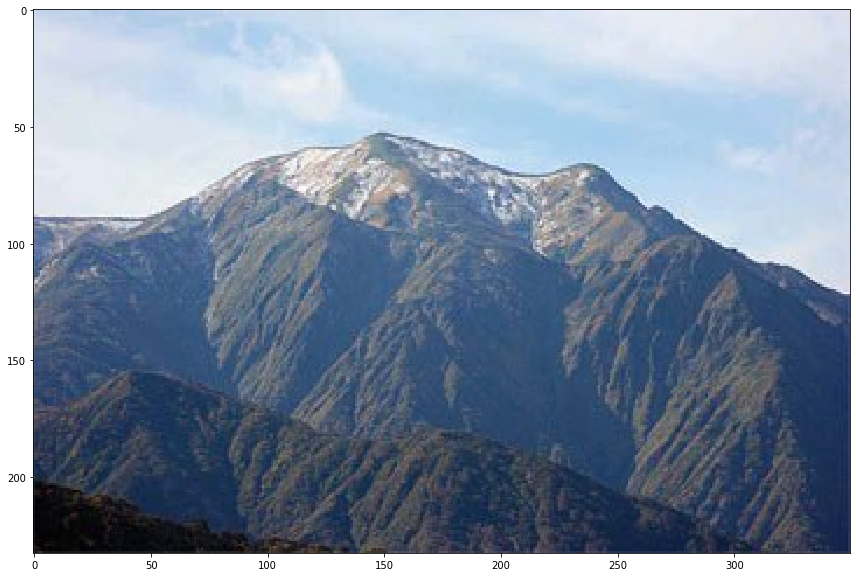

In [97]:
url="https://i2.wp.com/www.yunotani.or.jp/wp-content/uploads/2011/02/komagatake1.jpg?w=590"
local="hama.jpg"
req.urlretrieve(url, local)
img=cv2.imread("hama.jpg")
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print(img.shape)
l=img.shape[0]
m=img.shape[1]

### 5-5. 画像のモノクロ化

(233, 350)

<Figure size 432x288 with 0 Axes>

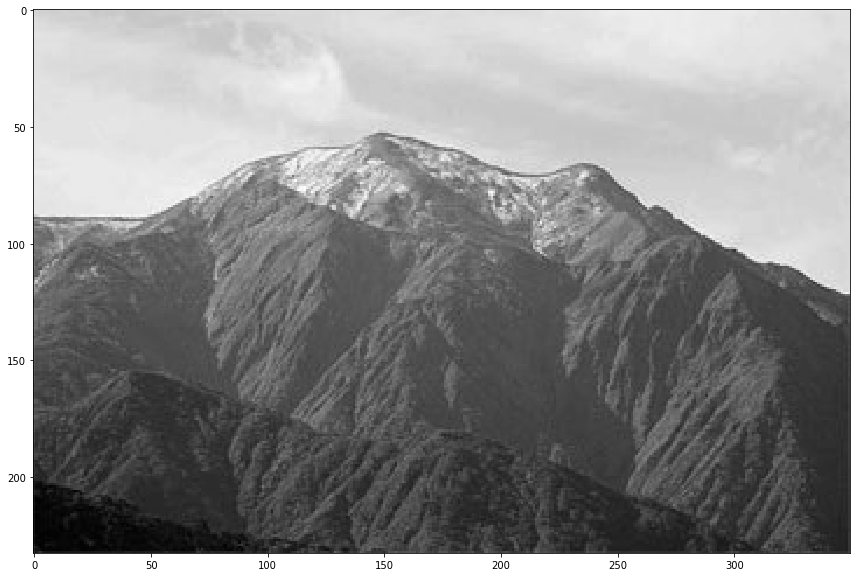

In [98]:
gry=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.gray()
plt.figure(figsize=(20,10))
plt.imshow(gry)

gry.shape

### 5-6.画像にノイズ付与

(233, 350)


<Figure size 432x288 with 0 Axes>

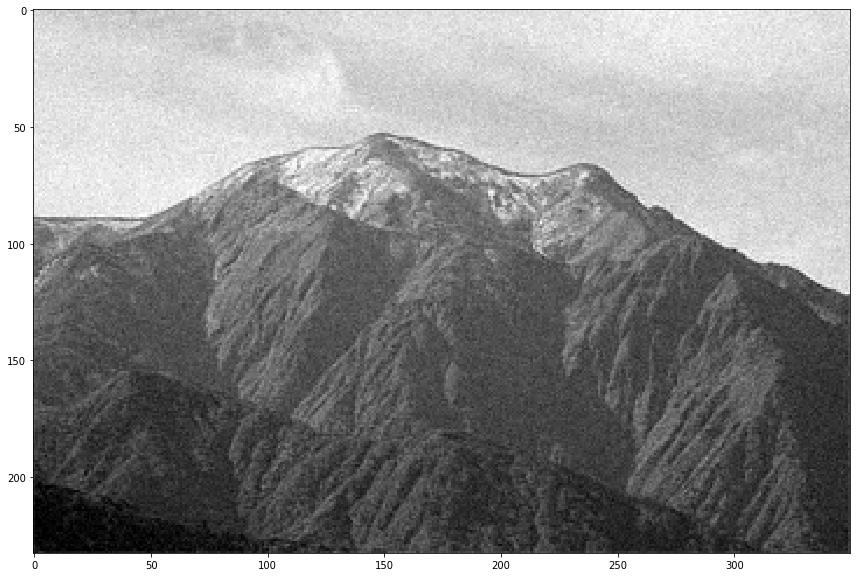

In [147]:
def addGaussianNoise(src):
    row,col= src.shape
    mean = 0
    var = 0.1
    sigma = 15
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = src + gauss/2

    return noisy

gry_noize=addGaussianNoise(gry)

plt.gray()
plt.figure(figsize=(20,10))
plt.imshow(gry_noize, vmin = 0, vmax = 255)

print(gry_noize.shape)

In [167]:
X=np.eye(m)
def run_fused_lasso(a,a1,a2):
    clf=FusedLassoADMM(alpha=a, fit_intercept=False,sparse_coef=a1, trend_coef=a2, tol=1e-8)
    x=[]
  
    for i in range(l):
        if i%100==0:
            print(i)
        y=gry_noize[i,:]
        clf.fit(X,y)
        x.append(clf.coef_)
    x=np.array(x)
    
    plt.figure(figsize=(20,10))
    plt.imshow(x,vmin=0,vmax=255)
    
    return x

0
100
200


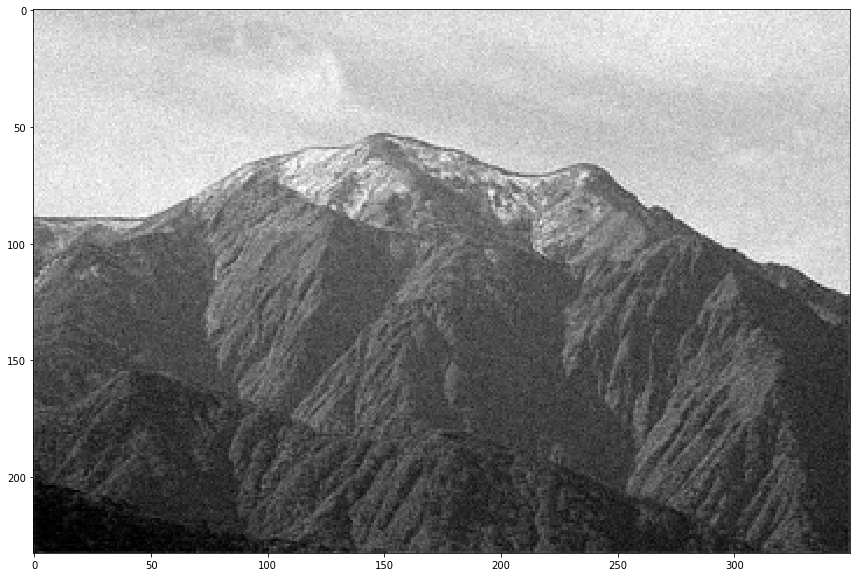

In [168]:
x=run_fused_lasso(0.1,0.1,0.1)

0
100
200


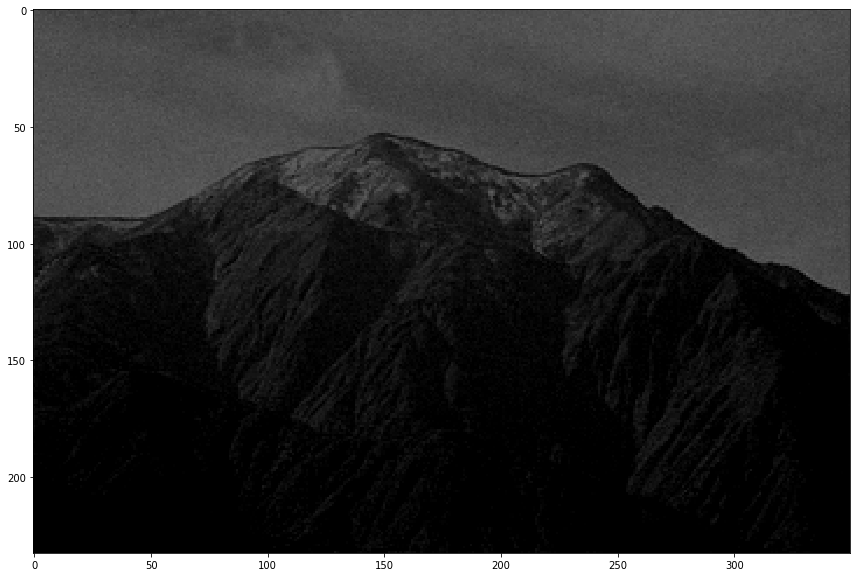

In [172]:
x=run_fused_lasso(0.1,2,0.1)

sparse_coefを大きくすると、出力結果のスパース性が強くなる（暗くなる）

0
100
200


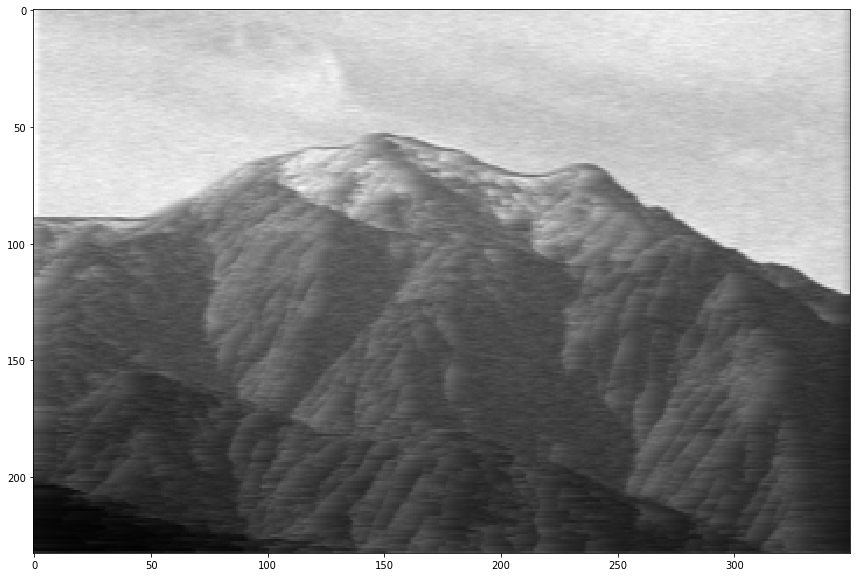

In [173]:
x=run_fused_lasso(0.1,0.1,2)

trend_coefを大きくすると、滑らかになる